## Libraries

In [1]:
# Main libraries installation
!pip install gdown pykml basemap contextily > nul


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Data download and extraction
import gdown
import zipfile
import os

# KML parsing
import pykml
from pykml import parser
from lxml import etree

# Geospatial data manipulation and visualization
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

# Input/Output operations
from io import BytesIO

# Basemaps and context tiles
import contextily as cx

# Data retrieval and manipulation
import requests
import pandas as pd

# Interactive visualizations
import plotly.express as px

# Interactive maps
import folium
from folium.plugins import MarkerCluster

# Displaying Matplotlib plots inline
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Data Ingestion

In [3]:
# Read and parse KML file
with open("data/jp_kml/japan_boundaries.kml", "r") as f:
    kml = parser.parse(f)

In [4]:
# Print the parsed KML content
print(kml)

In [5]:
# KML file URL
url = 'https://kmlnetworklink.gsi.go.jp/kmlnetworklink/kml/gsi_ort.kml'

# Download the content of the KML file
response = requests.get(url)
kml_content = response.content

# Save the KML content to a local temporary file
local_filename = 'data/jp_kml/output/japan_boundaries.kml'
with open(local_filename, 'wb') as f:
    f.write(kml_content)

In [6]:
# Read the content of the KML file
with open("data/jp_kml/output/japan_boundaries.kml", "rb") as f:
    kml_content = f.read()

# Parse the content of the KML
root = etree.fromstring(kml_content)

# Find all Placemarks in the document
places = root.findall(".//{http://www.opengis.net/kml/2.2}Placemark")

# Now, 'places' should contain a list of Placemark elements
# You can iterate over them and perform the necessary operations
for place in places:
    # Perform the needed operations with each Placemark
    # For example, you can access coordinates with:
    coordinates = place.find(".//{http://www.opengis.net/kml/2.2}coordinates").text
    print("Coordinates:", coordinates)

## Data Exploring

In [7]:
# Iterate over Placemarks and print information
for placemark in kml.getroot().Document.findall('.//{http://www.opengis.net/kml/2.2}Placemark'):
    # Find the ExtendedData element
    extended_data_element = placemark.find('.//{http://www.opengis.net/kml/2.2}ExtendedData')

    if extended_data_element is not None:
        # Find the SchemaData element within ExtendedData
        schema_data_element = extended_data_element.find('.//{http://www.opengis.net/kml/2.2}SchemaData')

        if schema_data_element is not None:
            # Find SimpleData elements within SchemaData
            name_element = schema_data_element.find('.//{http://www.opengis.net/kml/2.2}SimpleData[@name="nam"]')
            district_element = schema_data_element.find('.//{http://www.opengis.net/kml/2.2}SimpleData[@name="laa"]')

            # Extract information or provide default values if not found
            name = name_element.text if name_element is not None and name_element.text is not None else "Nombre no encontrado"
            district = district_element.text if district_element is not None and district_element.text is not None else "Distrito no encontrado"
            
            # Extract coordinates
            coordinates = placemark.find('.//{http://www.opengis.net/kml/2.2}Polygon/{http://www.opengis.net/kml/2.2}outerBoundaryIs/{http://www.opengis.net/kml/2.2}LinearRing/{http://www.opengis.net/kml/2.2}coordinates').text.strip()

            # Print information
            print("Prefecture:", name)
            print("District/Province:", district)
            print("Coordinates:", coordinates)
            print("\n")
        else:
            print("SchemaData not found in ExtendedData.")
    else:
        print("ExtendedData not found in Placemark.")

Prefecture: Hokkai Do
District/Province: Sapporo Shi
Coordinates: 141.449798583984,43.1633338928223 141.447692871094,43.1572685241699 141.453994750977,43.1404685974121 141.455291748047,43.1246681213379 141.445098876953,43.1020660400391 141.457901000977,43.0942001342773 141.459701538086,43.0996017456055 141.465194702148,43.1008682250977 141.467300415039,43.0988655090332 141.473999023438,43.0970001220703 141.474105834961,43.0950660705566 141.475799560547,43.09033203125 141.473999023438,43.0865325927734 141.471694946289,43.083667755127 141.473892211914,43.0751342773438 141.47200012207,43.0702667236328 141.483901977539,43.0610008239746 141.489700317383,43.058464050293 141.496795654297,43.0587997436523 141.498001098633,43.0505981445313 141.500900268555,43.0514678955078 141.505905151367,43.0217323303223 141.496795654297,43.0236015319824 141.486297607422,43.023265838623 141.487701416016,43.0182685852051 141.489501953125,43.0150680541992 141.484603881836,43.0130653381348 141.482803344727,43.00

In [8]:
# Create a list to store Placemark geometries
geometries = []

# Iterate over Placemarks and create geometries
for placemark in kml.getroot().Document.findall('.//{http://www.opengis.net/kml/2.2}Placemark'):
    # Find the ExtendedData element
    extended_data_element = placemark.find('.//{http://www.opengis.net/kml/2.2}ExtendedData')

    if extended_data_element is not None:
        # Find the SchemaData element within ExtendedData
        schema_data_element = extended_data_element.find('.//{http://www.opengis.net/kml/2.2}SchemaData')

        if schema_data_element is not None:
            # Find SimpleData elements within SchemaData
            name_element = schema_data_element.find('.//{http://www.opengis.net/kml/2.2}SimpleData[@name="nam"]')
            district_element = schema_data_element.find('.//{http://www.opengis.net/kml/2.2}SimpleData[@name="laa"]')

            # Extract information or provide default values if not found
            name = name_element.text if name_element is not None and name_element.text is not None else "Nombre no encontrado"
            district = district_element.text if district_element is not None and district_element.text is not None else "Distrito no encontrado"
            
            # Extract coordinates
            coordinates = placemark.find('.//{http://www.opengis.net/kml/2.2}Polygon/{http://www.opengis.net/kml/2.2}outerBoundaryIs/{http://www.opengis.net/kml/2.2}LinearRing/{http://www.opengis.net/kml/2.2}coordinates').text.strip()

            # Parse coordinates and create a Shapely geometry
            coords = [tuple(map(float, coord.split(','))) for coord in coordinates.split()]
            if len(coords) > 2:
                # It's a polygon
                geometry = Polygon(coords)
            else:
                # It's a point
                geometry = Point(coords[0])

            geometries.append({'name': name, 'district': district, 'geometry': geometry})
        else:
            print("SchemaData not found in ExtendedData.")
    else:
        print("ExtendedData not found in Placemark.")

# Create a GeoDataFrame with GeoPandas
gdf = gpd.GeoDataFrame(geometries, geometry=gpd.GeoSeries([geom['geometry'] for geom in geometries]))

# Save as GeoJSON
gdf.to_file("data/jp_kml/output/output.geojson", driver="GeoJSON")

# Save as a Shapefile in a temporary file
temp_shapefile_path = "data/jp_kml/output/temp_shapefile.shp"
gdf.to_file(temp_shapefile_path, driver="ESRI Shapefile")

# Read the Shapefile
gdf_kml = gpd.read_file(temp_shapefile_path)

# Display the GeoDataFrame
print(gdf_kml)

           name       district  \
0     Hokkai Do    Sapporo Shi   
1     Hokkai Do   Hakodate Shi   
2     Hokkai Do      Otaru Shi   
3     Hokkai Do  Asahikawa Shi   
4     Hokkai Do    Muroran Shi   
...         ...            ...   
2909   Tokyo To            UNK   
2910   Tokyo To            UNK   
2911   Tokyo To            UNK   
2912   Tokyo To            UNK   
2913  Aichi Ken            UNK   

                                               geometry  
0     POLYGON ((141.44980 43.16333, 141.44769 43.157...  
1     POLYGON ((140.86501 42.01013, 140.86800 42.008...  
2     POLYGON ((141.24820 43.15973, 141.24680 43.158...  
3     POLYGON ((142.43280 43.94814, 142.43790 43.944...  
4     POLYGON ((140.99080 42.43800, 140.99680 42.436...  
...                                                 ...  
2909  POLYGON ((139.80595 35.58558, 139.79480 35.592...  
2910  POLYGON ((140.05172 31.43784, 140.05053 31.437...  
2911  POLYGON ((140.29860 30.47233, 140.28740 30.482...  
2912  POLYG

## Data Visualization

In [9]:
# Set the Coordinate Reference System (CRS) to EPSG:4326
gdf_kml = gdf_kml.set_crs(4326, allow_override=True)

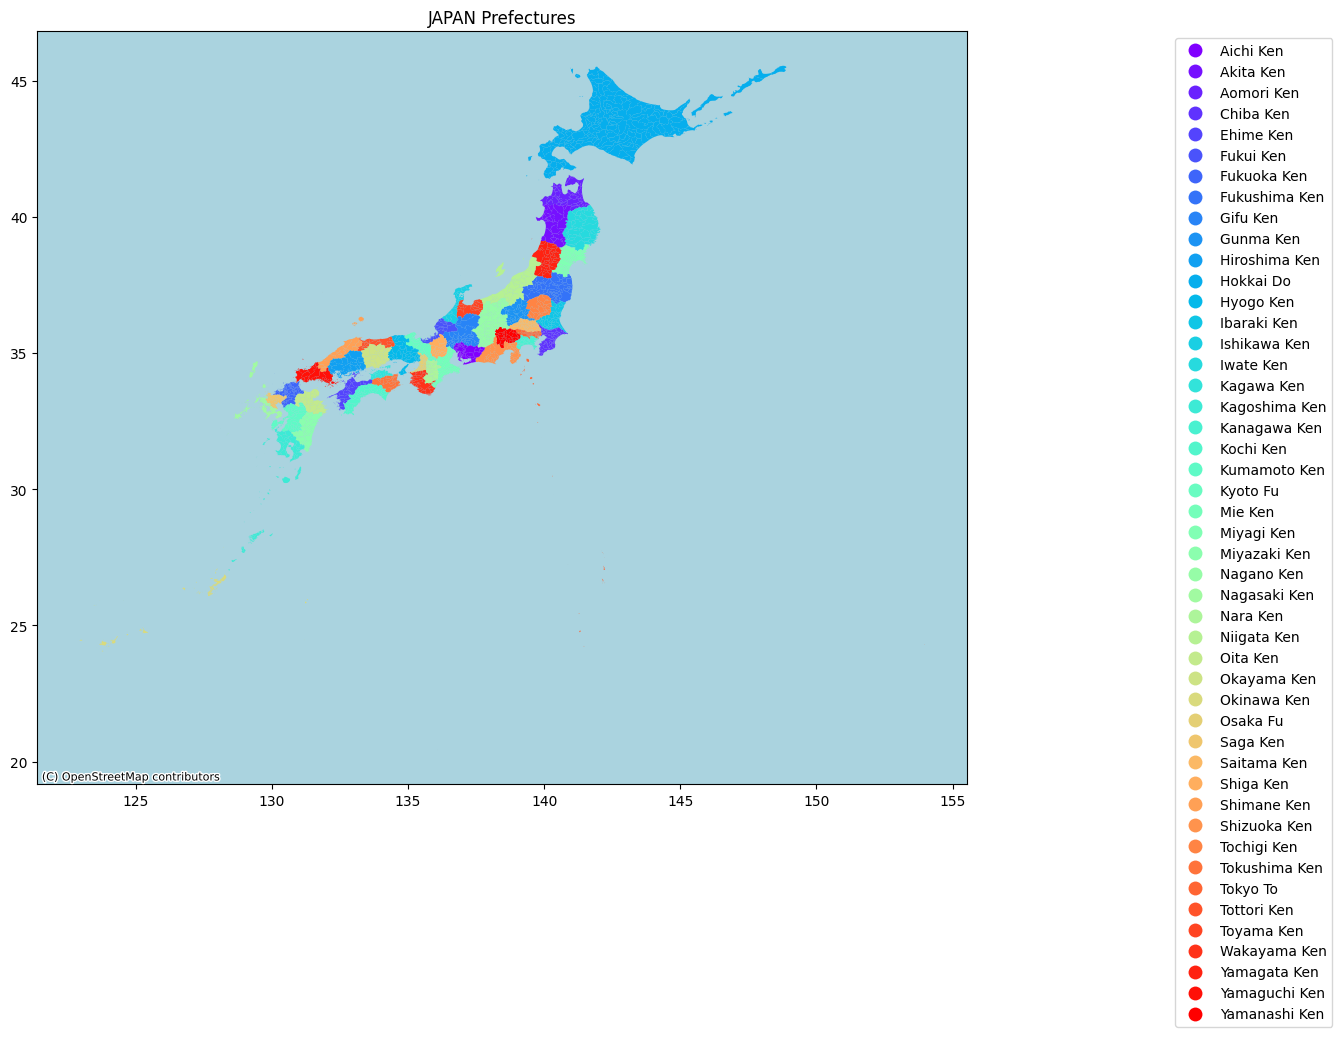

In [10]:
# Visualize the vector file of county subdivisions
fig, ax = plt.subplots(figsize=(12, 10))
gdf_kml.plot(ax=ax, column='name', cmap='rainbow', legend=True, legend_kwds={'bbox_to_anchor': (1.4, 1)})
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_title('JAPAN Prefectures')
plt.show()